In [1]:
import pandas as pd
import numpy as np

from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и обработка данных

In [2]:
!wget https://archive.ics.uci.edu/static/public/52/ionosphere.zip
!mkdir ion_data
!unzip ionosphere.zip -d ion_data
!rm ionosphere.zip

--2023-10-06 17:51:37--  https://archive.ics.uci.edu/static/public/52/ionosphere.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘ionosphere.zip’

ionosphere.zip          [  <=>               ]  29.28K   142KB/s    in 0.2s    

2023-10-06 17:51:39 (142 KB/s) - ‘ionosphere.zip’ saved [29983]

Archive:  ionosphere.zip
  inflating: ion_data/Index          
  inflating: ion_data/ionosphere.data  
  inflating: ion_data/ionosphere.names  


In [2]:
df = pd.read_csv('ion_data/ionosphere.data', header=None)

Проверка типов данных признаков

In [3]:
pd.Series([str(df[name].dtype) for name in df.columns]).value_counts()

float64    32
int64       2
object      1
Name: count, dtype: int64

Кодирование категориального признака

In [4]:
df[34] = df[34].replace({'g': 1, 'b': 0})

Проверка выборки на наличие нулей

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
pd.DataFrame({'percent_missing': percent_missing})

,percent_missing
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


# Анализ признаков

Проверка зависимостей между признаками с помощью тепловой карты

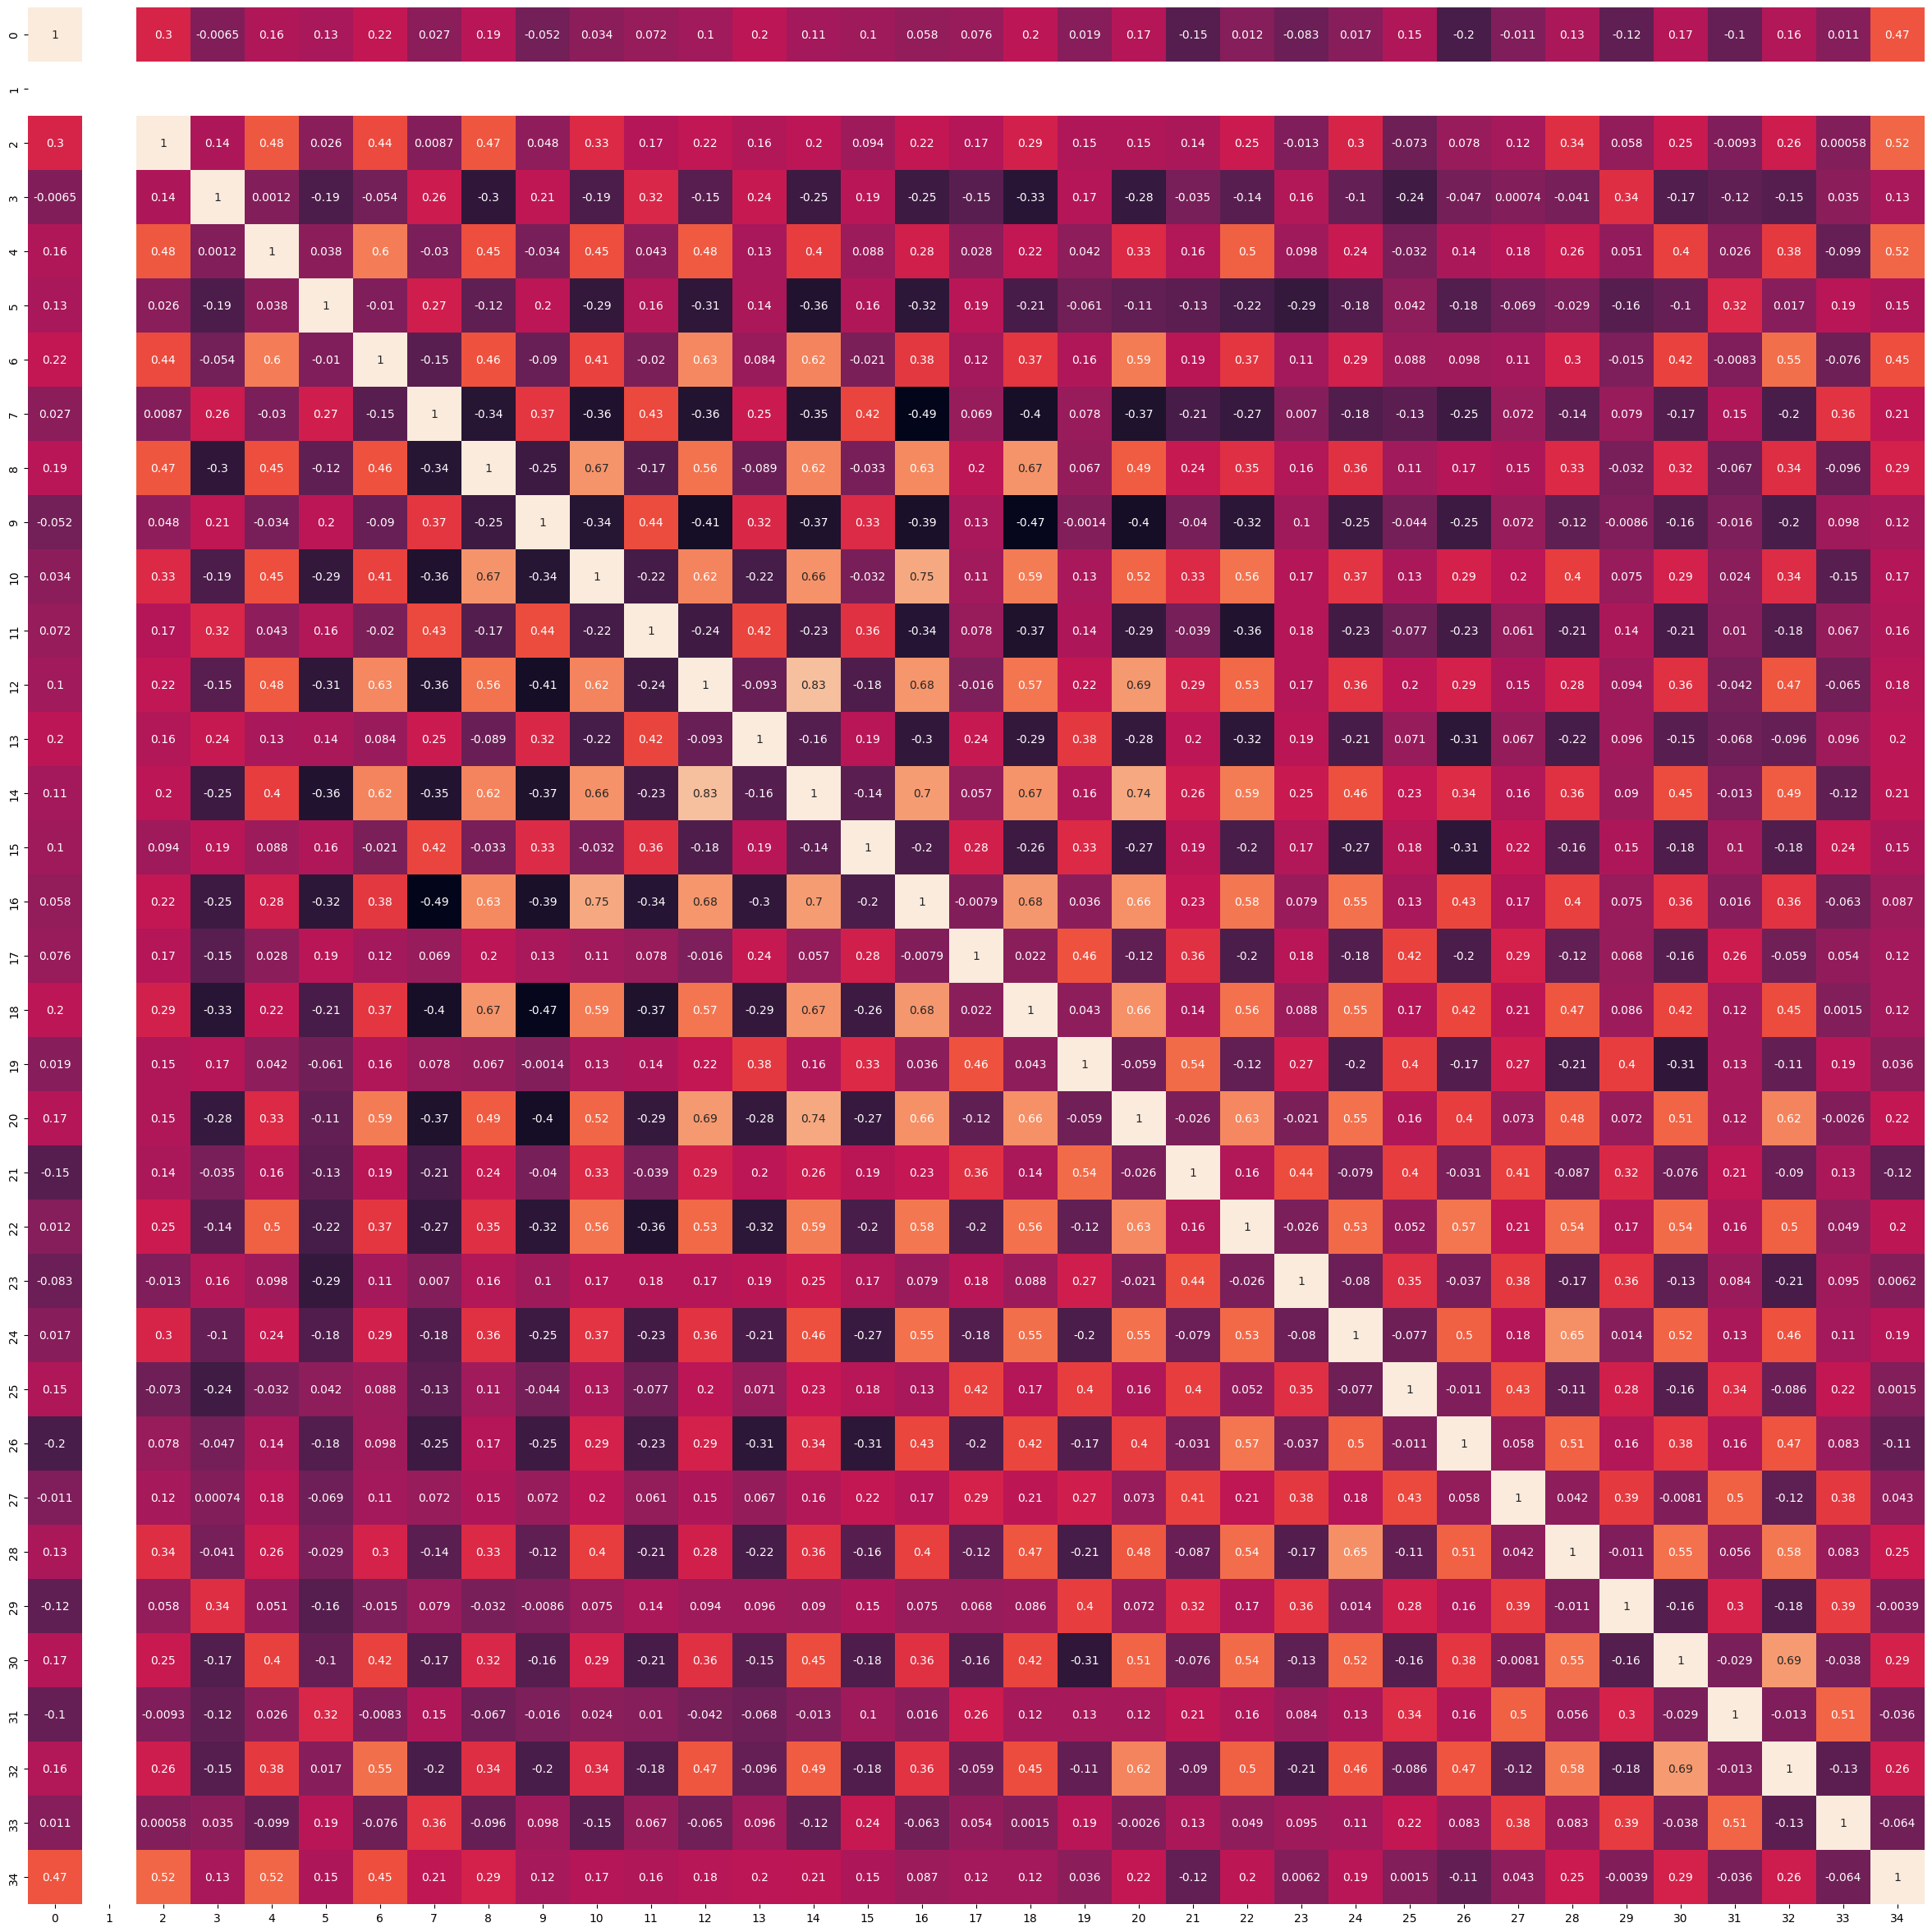

In [7]:
corrmat = df.corr()
plt.subplots(figsize=(30, 30))
sns.heatmap(corrmat, square=True, annot=True, cbar=False)
plt.show()

Вывод описательной статистики

In [8]:
C=len(df.columns)
L=len(df.index)
CN=df.count() #количество
NP=((L - CN) / L) * 100 #процент пропущенных значений
MN=df.min() #минимум
Q1=df.quantile(q=0.25) #первый квартиль
MA=df.mean() #среднее значение
ME=df.median() #медиана
Q3=df.quantile(q=0.75) #третий квартиль
MX=df.max() #максимум
ST=df.std() #стандартное отклонение
P=df.nunique() #мощность
IQ=Q3 - Q1 #интерквартильный размах

In [9]:
frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
frame=frame.T
f=pd.DataFrame(frame)
f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
f1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Количество,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
Первый квартиль,1.000000,0.000000,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,0.021120,-0.065265,0.000000,-0.073725,0.000000,-0.081705,0.000000,-0.225690,0.000000,-0.234670,0.000000,-0.243870,0.000000,-0.366885,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350,0.000000
Среднее,0.891738,0.000000,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,0.476183,0.155040,0.400801,0.093414,0.344159,0.071132,0.381949,-0.003617,0.359390,-0.024025,0.336695,0.008296,0.362475,-0.057406,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480,0.641026
Медиана,1.000000,0.000000,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,0.667980,0.028250,0.644070,0.030270,0.601940,0.000000,0.590910,0.000000,0.576190,0.000000,0.499090,0.000000,0.531760,0.000000,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000,1.000000
Третий квартиль,1.000000,0.000000,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,0.957895,0.482375,0.955505,0.374860,0.919330,0.308975,0.935705,0.195285,0.899265,0.134370,0.894865,0.188760,0.911235,0.164630,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660,1.000000
Максимум,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Стандартное отклонение,0.311155,0.000000,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,0.563496,0.494817,0.622186,0.494873,0.652828,0.458371,0.618020,0.496762,0.626267,0.519076,0.609828,0.518166,0.603767,0.527456,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337,0.480384
Мощность,2.000000,1.000000,219.000000,269.000000,204.000000,259.000000,231.000000,260.000000,244.000000,267.000000,246.000000,269.000000,238.000000,266.000000,234.000000,270.000000,254.000000,280.000000,254.000000,266.000000,248.000000,265.000000,248.000000,264.000000,256.000000,273.000000,256.000000,281.000000,244.000000,266.000000,243.000000,263.000000,245.000000,263.000000,2.000000


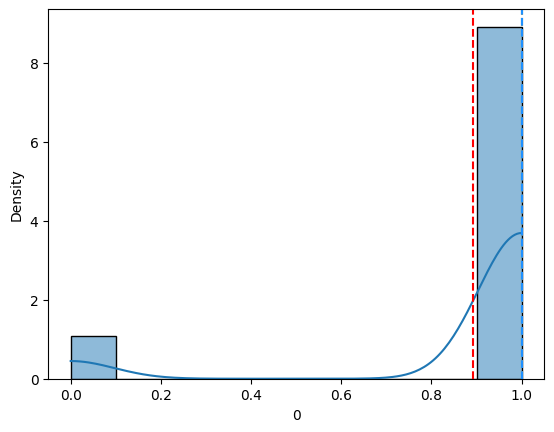

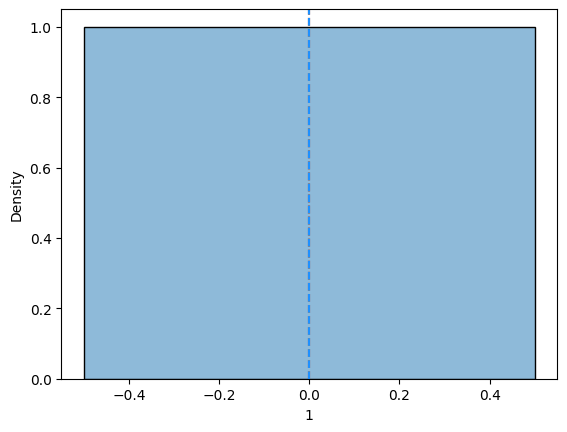

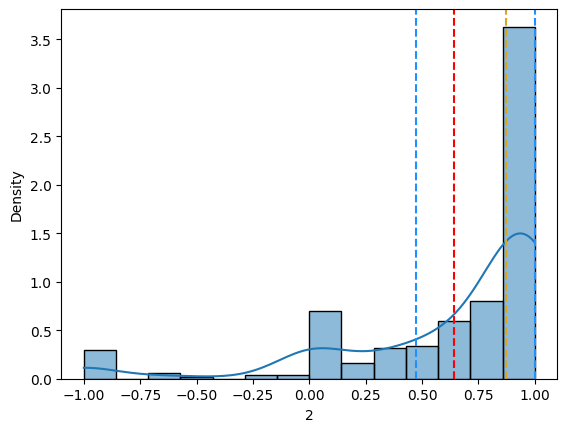

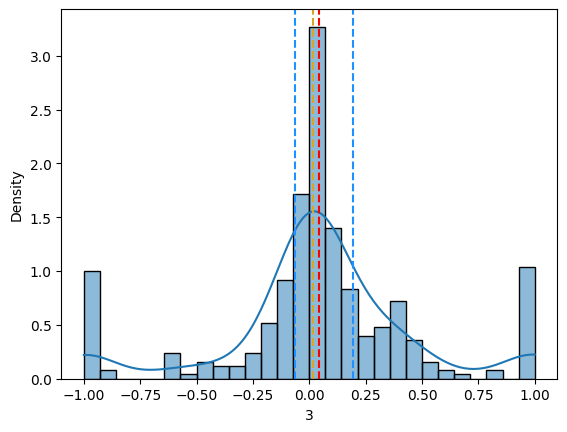

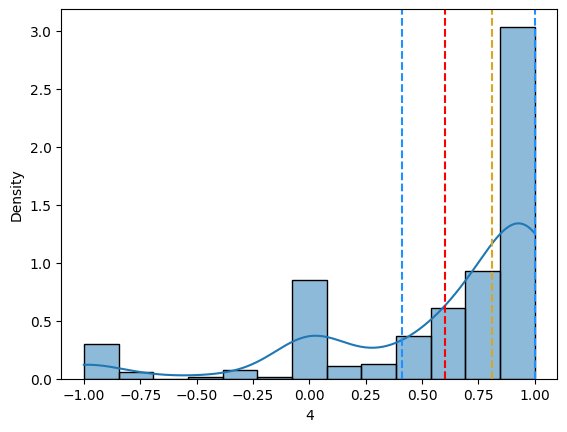

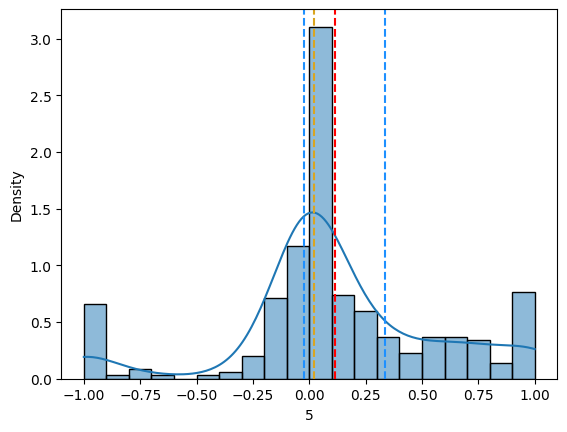

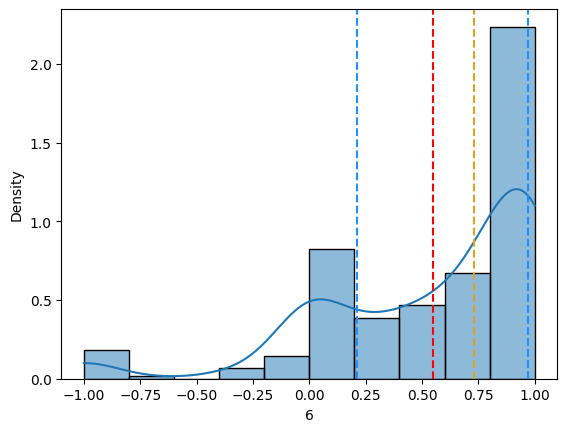

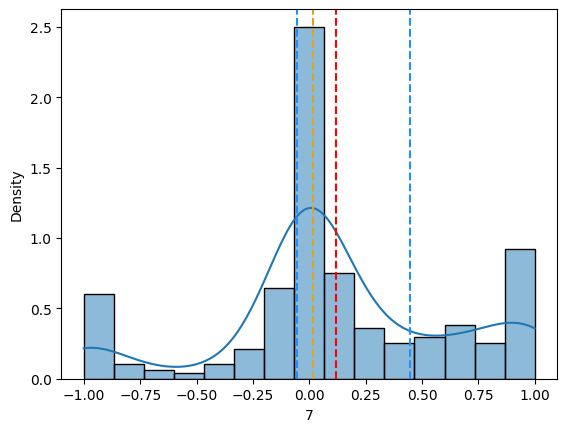

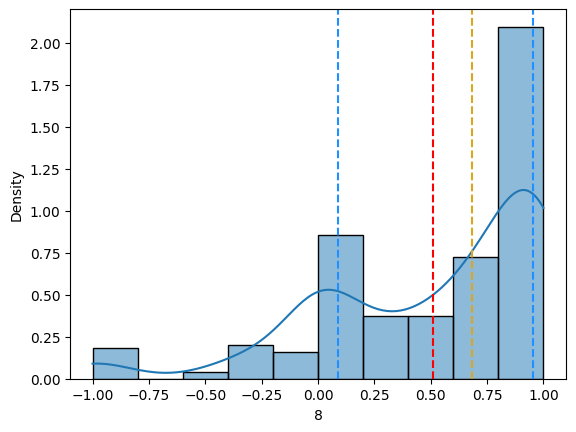

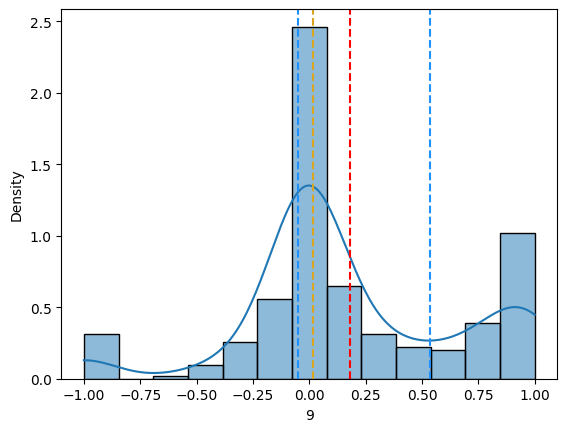

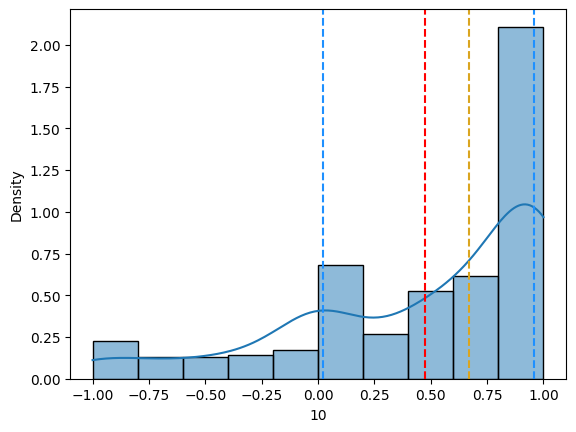

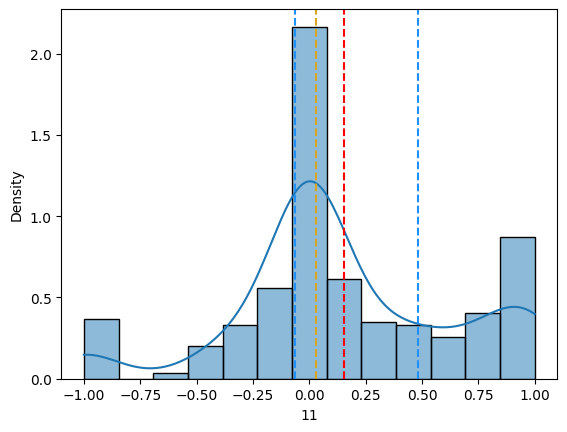

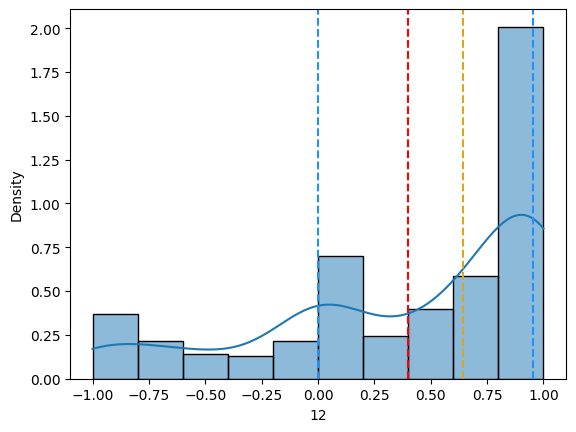

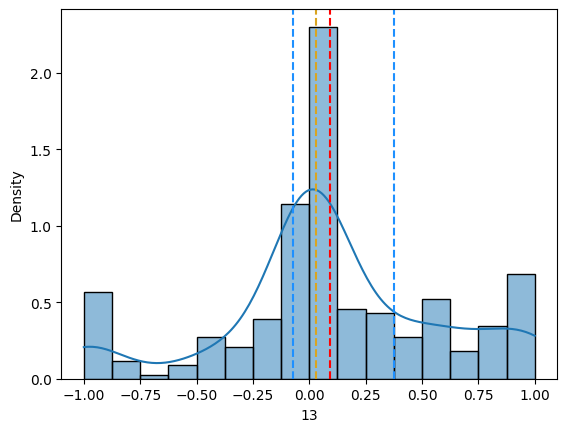

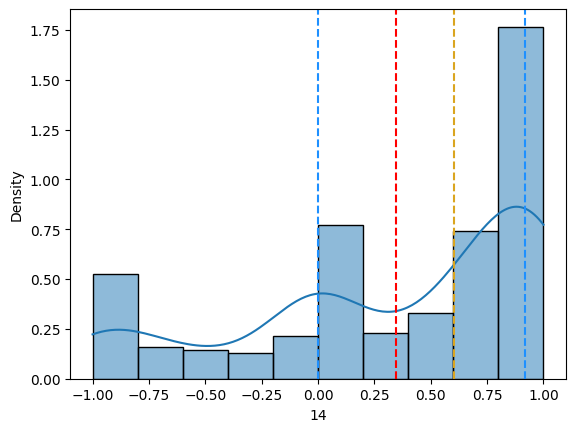

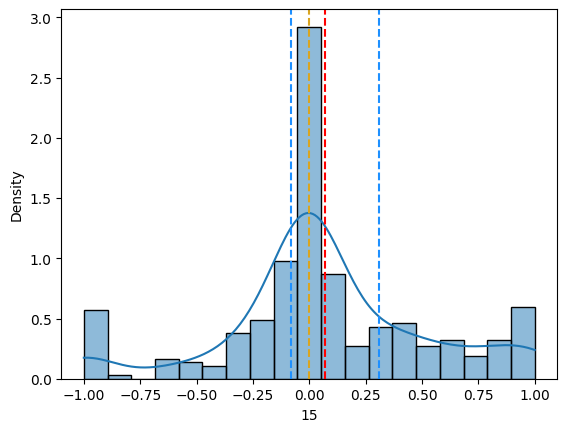

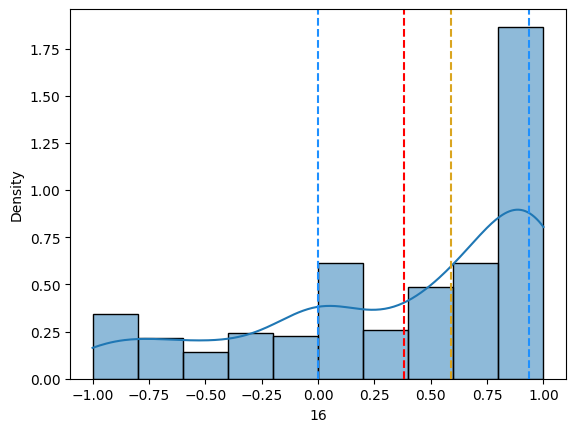

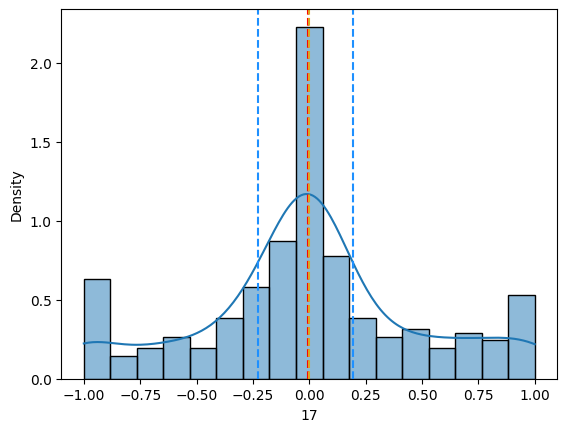

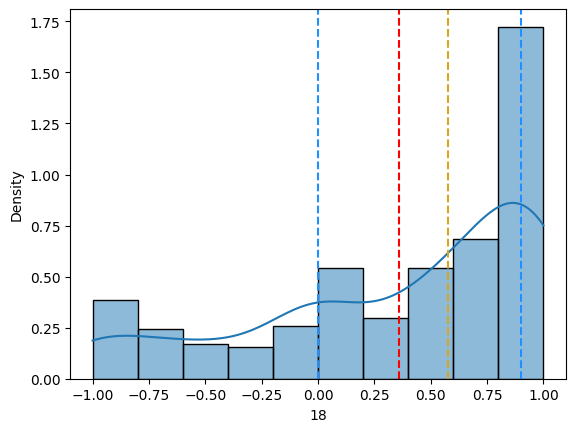

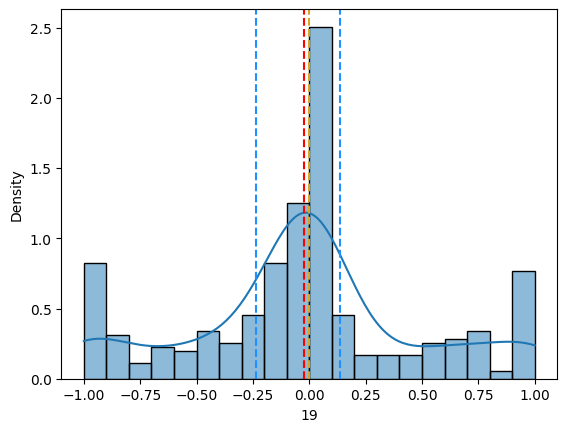

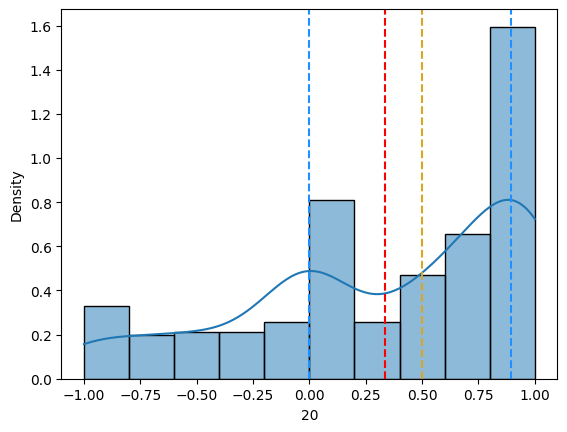

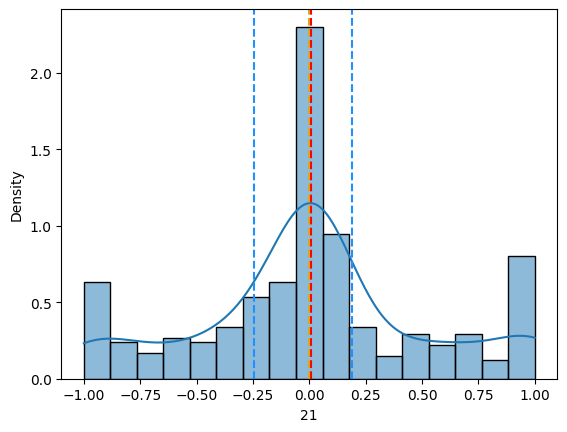

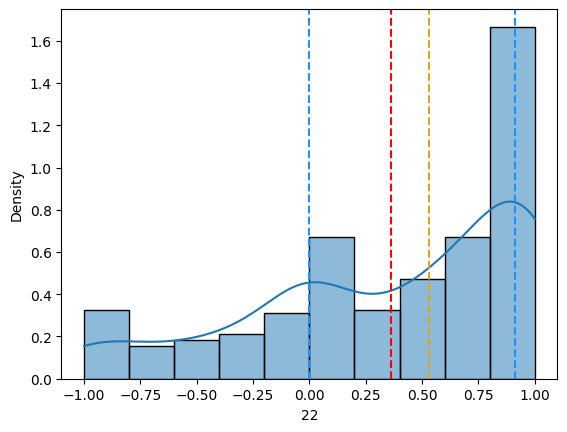

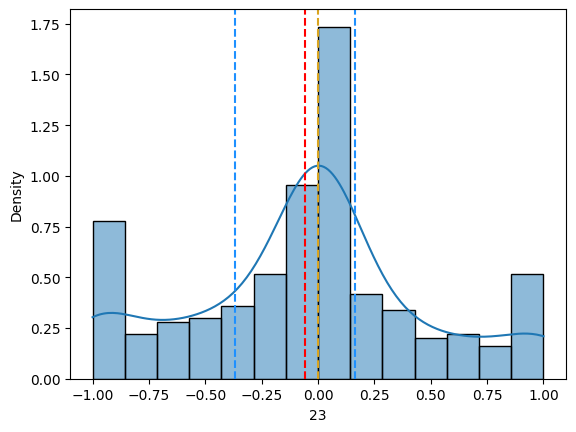

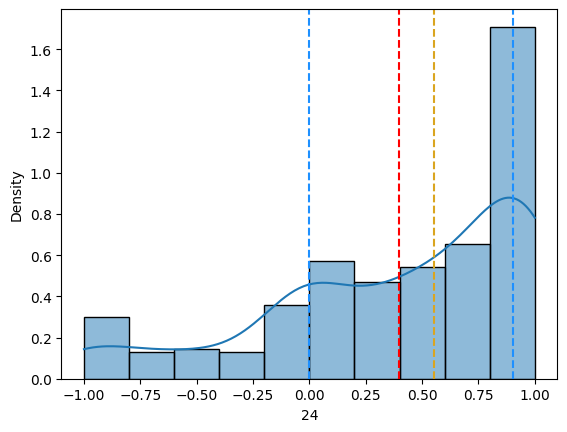

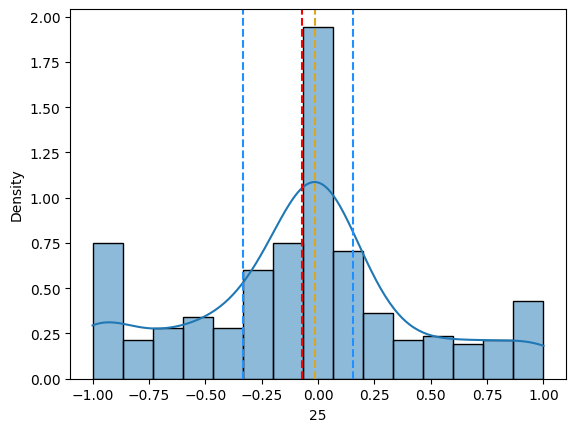

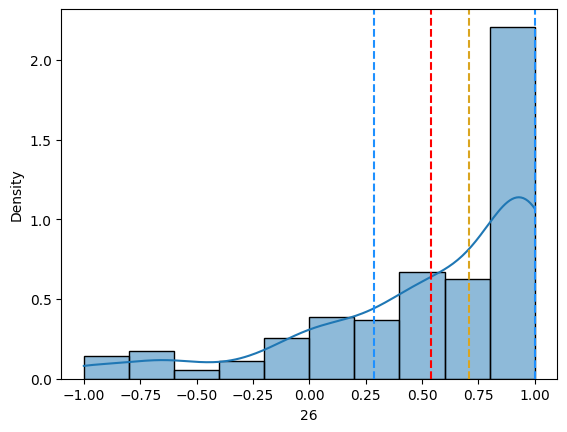

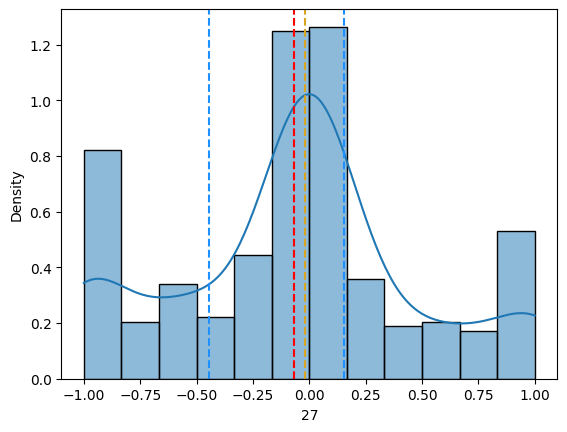

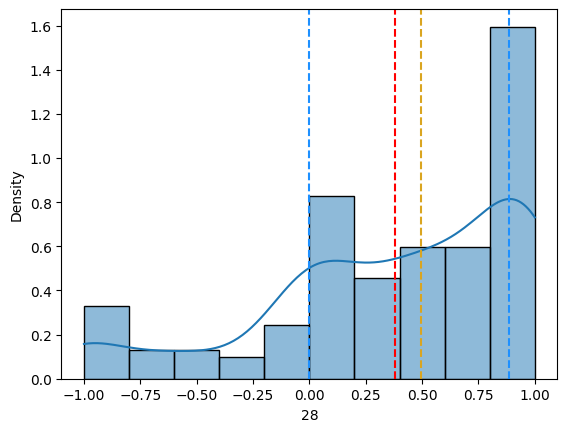

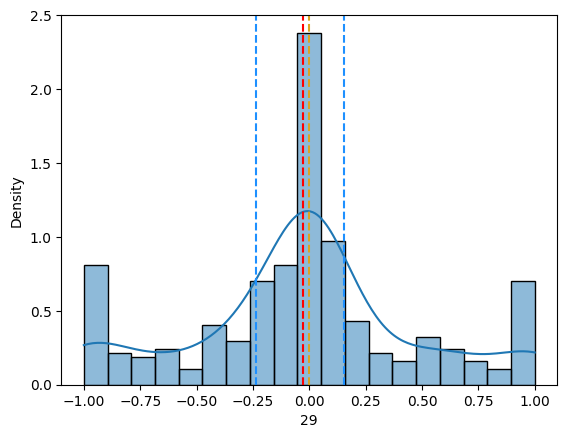

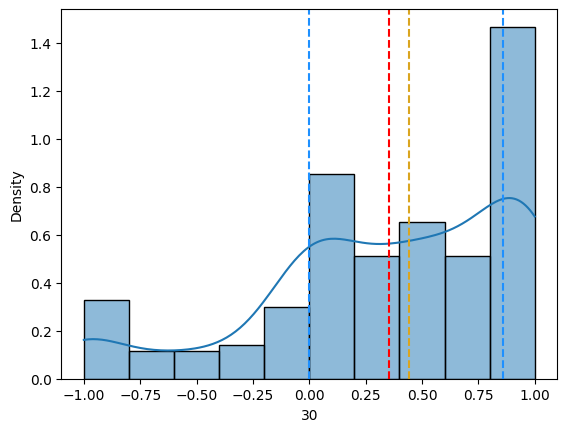

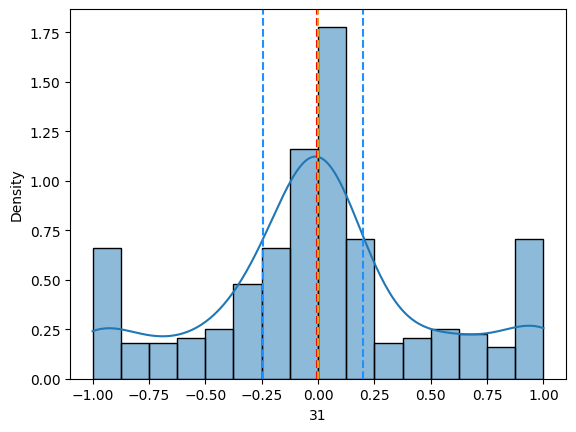

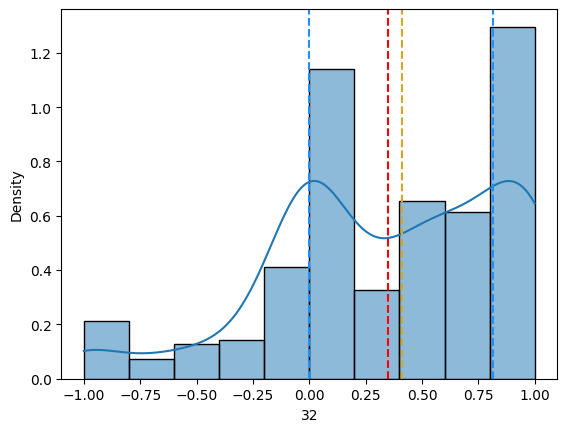

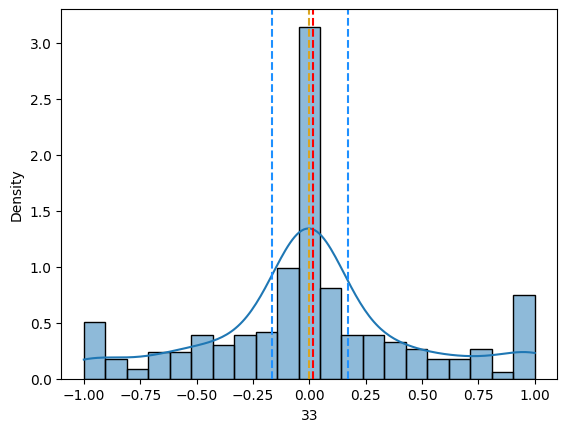

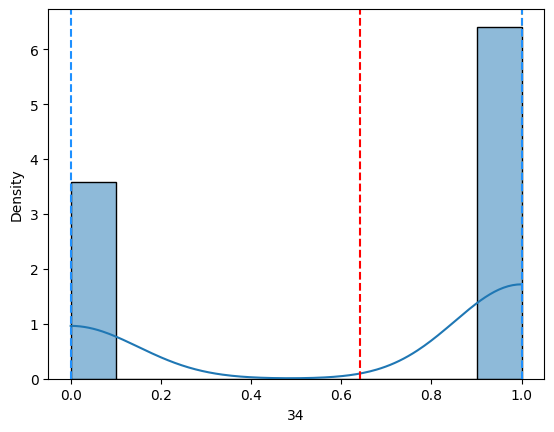

In [10]:
for i in df.columns:
    plt.figure(i)
    sns.histplot(df[i], kde=True, stat="density")
    plt.axvline(f.iloc[3][i], color="dodgerblue", ls='--') #первый квартиль
    plt.axvline(f.iloc[4][i], color="red", ls='--') #среднее
    plt.axvline(f.iloc[5][i], color="goldenrod", ls='--') #медиана
    plt.axvline(f.iloc[6][i], color="dodgerblue", ls='--') #третий квартиль
    plt.show()

На основании анализа статистических показателей и графиков, удалены следующие признаки

In [5]:
feats_to_drop = [1, 16, 19, 23, 25, 27, 29, 31, 33]
df.drop(feats_to_drop, axis=1, inplace=True)

Выделение целевой переменной

In [6]:
y = df[34].values
X = df.drop([34], axis=1).values

# Реализация алгоритма и построение модели

*Метрики*

In [7]:
def minkowski_distance(x1, x2, p=2):
    minkowski = np.sum(np.abs(x1-x2)**p)**(1/p)
    return minkowski

def euclidean_distance(x1, x2):
    euclidean = np.sqrt(np.sum((x1-x2)**2))
    return euclidean

def manhattan_distance(x1, x2):
    manhattan = np.sum(np.abs(x1-x2))
    return manhattan

*Реализация класса k-Nearest Neighbours*

In [8]:
class KNN_classifier():
    def __init__(self, k, metric=minkowski_distance, p=2) -> None:
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    
    def predict_one(self, x):
        neighbours = self._get_neighbours(x)
        predicted_class = max(set(neighbours), key=neighbours.count)
        return predicted_class

    def predict(self, x):
        return [self.predict_one(_) for _ in x]

    def score(self, x_test, y_test):
        predictions = []
        for x, y in zip(x_test, y_test):
            y_pred = self.predict_one(x)
            predictions.append(y_pred)
        
        accuracy = np.mean(y_test == predictions)
        return accuracy

    def _get_neighbours(self, x):
        distances = []
        # считаем дистанцию на всей тренировочной выборке
        for x_train, y_train in zip(self.X, self.y):
            distance = self.metric(x_train, x)
            distances.append((distance, y_train))

        # сортируем по возрастанию дистанции
        distances.sort(key=lambda d: d[0])

        # ищем соседей
        neighbours = [distances[i][1] for i in range(self.k)]
        return neighbours


Разбиение на тренировочную и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

Сравнение точности алгоритмов

In [34]:
class Scorer (object):
  def __init__(self, y_true, y_pred):
    tp, fp, _, fn = self._perf_measure(y_true, y_pred)
    self.tp = tp
    self.fp = fp
    self.fn = fn

  @staticmethod
  def _perf_measure(y_true, y_pred):
      TP = 0
      FP = 0
      TN = 0
      FN = 0

      for i in range(len(y_pred)): 
          if y_true[i] == y_pred[i] == 1:
            TP += 1
          if y_pred[i] == 1 and y_true[i] != y_pred[i]:
            FP += 1
          if y_true[i] == y_pred[i] == 0:
            TN += 1
          if y_pred[i] == 0 and y_true[i] != y_pred[i]:
            FN += 1

      return (TP, FP, TN, FN)

  def get_recall_score(self) -> float:
    return self.tp / (self.tp + self.fn)

  def get_precision_score(self) -> float:
    return self.tp / (self.tp + self.fp)

  def get_f1_score(self) -> float:
    return 2 * self.tp / (2 * self.tp + self.fp + self.fn)


In [11]:
metrics = {
  'Minkowski': minkowski_distance, 
  'Euclidean': euclidean_distance, 
  'Manhattan': manhattan_distance
}
neighbours_count = [3, 5, 8]

In [37]:
def get_scores_df(model: KNN_classifier, neighbours: list, metrics: dict) -> pd.DataFrame:
  scores = pd.DataFrame(columns=metrics.keys(), index=neighbours_count)

  for k in neighbours:
    row = []
    for metric in metrics.values():
      KNN = model(k, metric=metric).fit(X_train, y_train)
      y_pred = KNN.predict(X_test)
      scorer = Scorer(y_test, y_pred)
      row.append(scorer.get_f1_score())
    scores.loc[k] = row

  return scores

In [38]:
get_scores_df(KNN_classifier, neighbours_count, metrics)

,Minkowski,Euclidean,Manhattan
3,0.891892,0.891892,0.937063
5,0.899329,0.899329,0.943662
8,0.917808,0.917808,0.937063


In [39]:
get_scores_df(KNeighborsClassifier, neighbours_count, metrics)

,Minkowski,Euclidean,Manhattan
3,0.891892,0.891892,0.937063
5,0.899329,0.899329,0.943662
8,0.917808,0.917808,0.937063
